In [32]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.nn.functional as F


import numpy as np
import matplotlib.pyplot as plt
import time

### Importing data

In [33]:
from google.colab import drive
import imageio.v3 as iio
import glob

In [34]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
def normalize_x(x):
  x[1:2] = (x - x.mean(0))[1:2]/x.std(0)[1:2]
  return x

def normalize_y(y):
  y = (y - y.mean(0))/ y.std(0)
  return y

In [36]:
np_xtrain = np.empty( (85, 3, 128, 128) )
np_ytrain = np.empty((85, 128,128))

np_ytest = np.empty((60, 128,128))
np_xtest = np.empty((60,3, 128,128))

path = "/content/drive/My Drive/M1/Deep Learning for Image Analysis/Assignment 3/WARWICK/Train/"
path_test = "/content/drive/My Drive/M1/Deep Learning for Image Analysis/Assignment 3/WARWICK/Test/"

for i in range(1,86):
  if i <10: stri = "0"+str(i)
  else : stri = str(i)

  x = iio.imread(path+"image_"+stri+".png")
  y = iio.imread(path+"label_"+stri+".png")
  np_xtrain[i-1,:, :, :] = x.T/255
  np_ytrain[i-1,:] = y.T/255

  if i >60 : continue

  y = iio.imread(path_test+"label_"+stri+".png")
  x = iio.imread(path_test+"image_"+stri+".png")
  np_ytest[i-1,:] = y.T/255
  np_xtest[i-1,:] = x.T/255

34


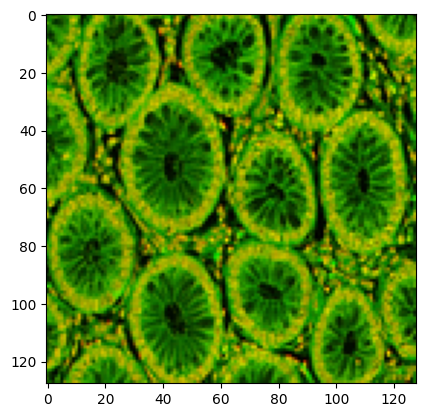

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


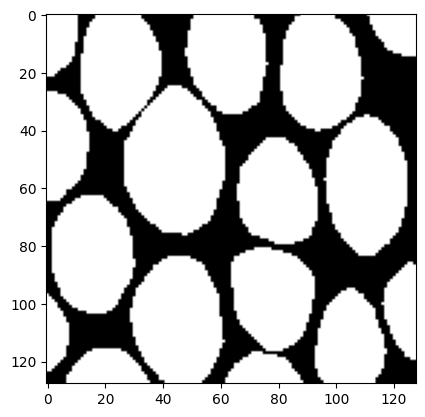

In [37]:
index = np.random.randint(60)
print(index)

plt.imshow(np_xtest[index].T)
plt.show()
plt.imshow(np_ytest[index].T, cmap="gray")
print(np_ytest[index].T)

In [38]:
np_xtrain = normalize_x(np_xtrain)
np_xtest = normalize_x(np_xtest)

In [39]:
means = np.mean(np_xtrain,0)
stds = np.std(np_xtrain,0)

tensor_x = torch.Tensor(np_xtrain)
tensor_y = torch.Tensor(np_ytrain)

tensor_xtest = torch.Tensor(np_xtest)
tensor_ytest = torch.Tensor(np_ytest)

my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
my_test = TensorDataset(tensor_xtest, tensor_ytest) # create your datset

In [40]:
segment_batch_size = 5

segment_trainloader = DataLoader(my_dataset, batch_size=segment_batch_size, shuffle=True) # create your dataloader

segment_testloader = DataLoader(my_test, batch_size=segment_batch_size, shuffle=True) # create your dataloader

###Segmentation adaptations

In [41]:
loss_segment = nn.BCEWithLogitsLoss()
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [42]:
def segment_learning(model_class, epochs, lr):
  model = model_class().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

  train_loss, test_loss = [0]*epochs, [0]*epochs
  train_DSC, test_DSC = [0]*epochs, [0]*epochs

  start = time.time()
  for t in range(epochs):
      #print(f"Epoch {t+1}\n-------------------------------")
      train_loss[t], train_DSC[t] = segment_train(segment_trainloader, model, loss_segment, optimizer)
      test_loss[t], test_DSC[t] = segment_test(segment_testloader, model, loss_segment)
      #scheduler.step()

  end = time.time()
  train_time = end-start
  #print("Done!")

  segment_plot_learning(train_loss, test_loss, train_DSC, test_DSC, lr, train_time, epochs)

  return model

In [43]:
def segment_train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()

    losses=np.array([])
    correct = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        binary_pred = (pred > 0.5).float()

        loss = loss_fn(pred, y)
        losses=np.append(losses, loss.item())

        correct += DSC(binary_pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 5 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)

            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


    DSC_score = correct / num_batches

    #visualise(np.random.randint(segment_batch_size), binary_pred)

    return np.mean(losses), DSC_score.item()

In [44]:
def visualise(index, tensor):
    array = tensor.cpu().detach().numpy()

    plt.imshow(array[index].T)
    plt.show()

In [45]:
def segment_test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            binary_pred = (pred > 0.5).float()

            test_loss += loss_fn(pred, y).item()
            correct += DSC(binary_pred, y)

    test_loss /= num_batches
    correct /= num_batches
    # print(f"Test Error: \n DSC: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, correct.item()

In [46]:
def segment_plot_learning(trainloss, testloss, trainacc, testacc, lr, traintime, epochs):
  fig, (ax1, ax2) = plt.subplots(1,2)
  fig.set_figwidth(15)
  fig.suptitle(f"| Batch size:{segment_batch_size} | Learning rate:{lr} | Number of epochs:{epochs} | Training time:{int(traintime)} seconds")

  ax1.plot(trainloss, label=f"Final train loss : {trainloss[-1]:f}")
  ax1.plot(testloss, label=f"Final test loss : {testloss[-1]:f}")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Loss")
  ax1.set_title("Losses")
  ax1.legend()

  ax2.plot(trainacc, label=f"Final train DSC : {trainacc[-1]:f}")
  ax2.plot(testacc, label=f"Final test DSC : {testacc[-1]:f}")
  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("DSC(A,B)")
  ax2.set_title("Dice Score")
  ax2.legend()

###Building the network

In [47]:
class CNN_segment(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 5, stride=1, padding=2)
        self.relu3 = nn.ReLU()

        self.tconv1 = nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1)
        self.relu4 = nn.ReLU()
        self.tconv2 = nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1)
        self.relu5 = nn.ReLU()
        self.sm = nn.Softmax(1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)

        x = self.tconv1(x)
        x = self.relu4(x)
        x = self.tconv2(x)
        x = self.relu5(x)
        x = self.sig(x)
        x = x.squeeze(dim=1)

        return x #+ (0.01**0.5)*torch.randn(x.shape)

In [48]:
class shallower_CNN_segment(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 50, 3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.tconv = nn.ConvTranspose2d(50, 1, 4, stride=2, padding=1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.pool(x)

        x = self.tconv(x)
        x = self.sig(x)
        x = x.squeeze(dim=1) # Matching shape of the labels

        return x

In [49]:
def DSC(a,b):
  """
  Returns the Dice SCore between two tensors
  param a: one of the tensors
  param b: the second tensor
  """
  return 2*torch.sum(a==b) / (a.numel()+b.numel())

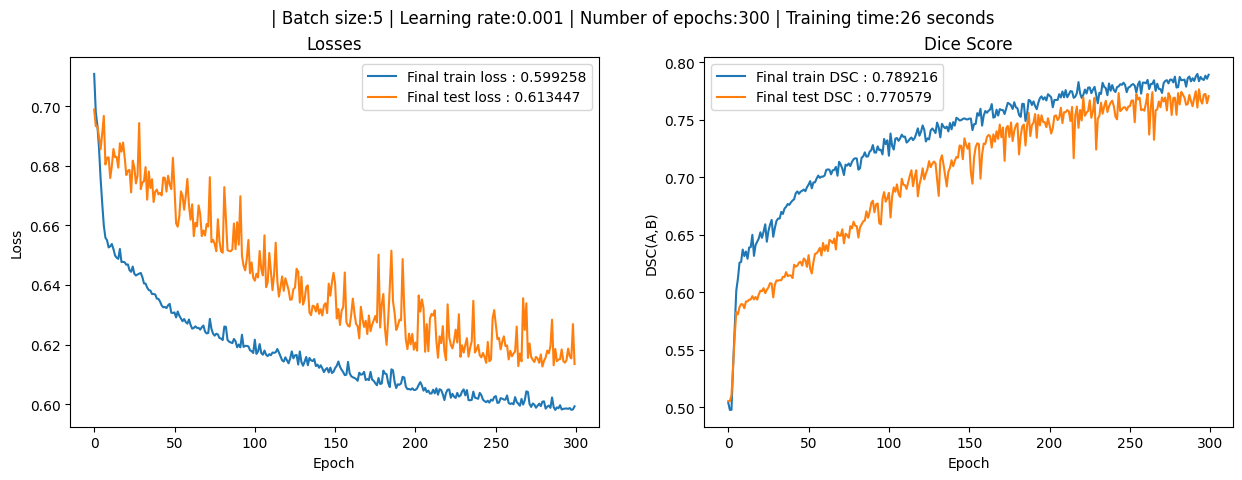

In [50]:
cnn_segment2 = segment_learning(shallower_CNN_segment, 300, 0.001)

In [83]:
def compare_out(trained_model, index):
  tensor_im = (trained_model(torch.Tensor(np_xtest[index]).to(device))>0.5).float()

  im = tensor_im.detach().to("cpu").numpy()

  figure = plt.figure(figsize=(8,3))

  figure.add_subplot(1,3, 1)
  plt.imshow(np_xtest[index].T)
  plt.title("X image")
  plt.axis("off")

  label = np_ytest[index]
  figure.add_subplot(1,3, 2)
  plt.imshow(label.T, "gray")
  plt.title("Label")
  plt.axis("off")

  figure.add_subplot(1,3, 3)
  plt.imshow(im.T, "gray")
  plt.axis("off")
  plt.title("Model prediction")

  dsc = DSC(tensor_im, torch.tensor(label).to(device)).item()

  figure.suptitle(f"Test image number {index+1} | Dice Score : {dsc}")
  plt.show()

  return dsc

In [68]:
max=0
min=1
for _ in range(20):
  i = np.random.randint(60)
  tensor_im = (cnn_segment2(torch.Tensor(np_xtest[i]).to(device))>0.5).float()
  tensor_label = torch.tensor(np_ytest[i]).to(device)

  dsc = DSC(tensor_im, tensor_label).item()
  if dsc > max:
    max = dsc
    argmax = i

  if dsc < min:
    min = dsc
    argmin = i

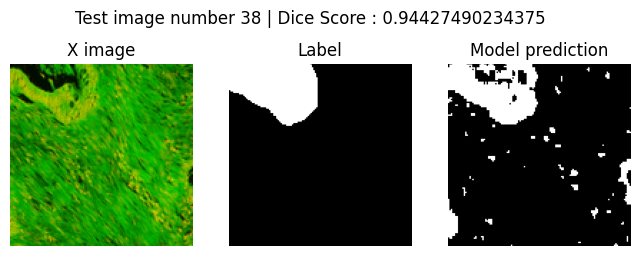

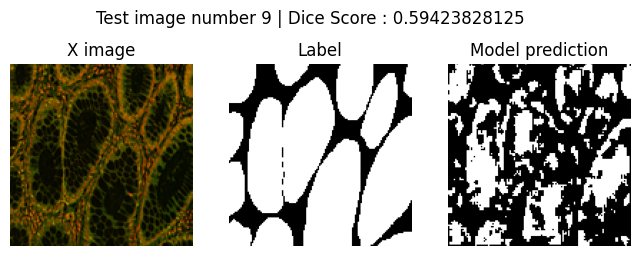

0.59423828125

In [84]:
compare_out(cnn_segment2, argmax)
compare_out(cnn_segment2, argmin)

##2.2

###Noisy input

In [87]:
def noisy_segment_train(dataloader, model, loss_fn, optimizer, std):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()

    losses=np.array([])
    correct = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Adding noise :
        X += (torch.randn(X.shape)*std).to(device)

        # Compute prediction error
        pred = model(X)
        binary_pred = (pred > 0.5).float()

        loss = loss_fn(pred, y)
        losses=np.append(losses, loss.item())

        correct += DSC(binary_pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 5 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)

            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


    DSC_score = correct / num_batches

    #visualise(np.random.randint(segment_batch_size), binary_pred)

    return np.mean(losses), DSC_score.item()

def noisy_segment_learning(model_class, epochs, lr, noise_std):
  model = model_class().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10)

  train_loss, test_loss = [0]*epochs, [0]*epochs
  train_DSC, test_DSC = [0]*epochs, [0]*epochs

  start = time.time()
  for t in range(epochs):
      #print(f"Epoch {t+1}\n-------------------------------")
      train_loss[t], train_DSC[t] = noisy_segment_train(segment_trainloader, model, loss_segment, optimizer, noise_std)
      test_loss[t], test_DSC[t] = segment_test(segment_testloader, model, loss_segment)
      #scheduler.step()

  end = time.time()
  train_time = end-start
  print("Done!")

  segment_plot_learning(train_loss, test_loss, train_DSC, test_DSC, lr, train_time, epochs)

  return model

Done!


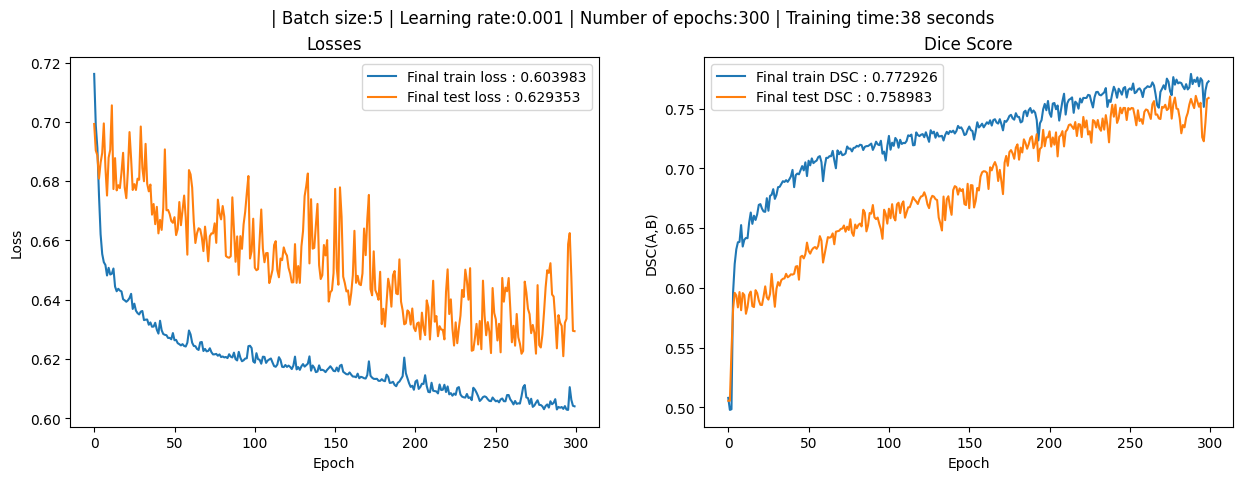

In [88]:
noisy_segment_cnn = noisy_segment_learning(shallower_CNN_segment, 300, 0.001, 0.03)

###Dropout

In [91]:
class dropout_CNN_segment(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.conv2 = nn.Conv2d(16, 50, 3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.tconv = nn.ConvTranspose2d(50, 1, 4, stride=2, padding=1)
        self.sig = nn.Sigmoid()

    def forward(self, x):

        x = self.conv1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.pool(x)

        x = self.tconv(x)
        x = self.sig(x)
        x = x.squeeze(dim=1) # Matching shape of the labels

        return x

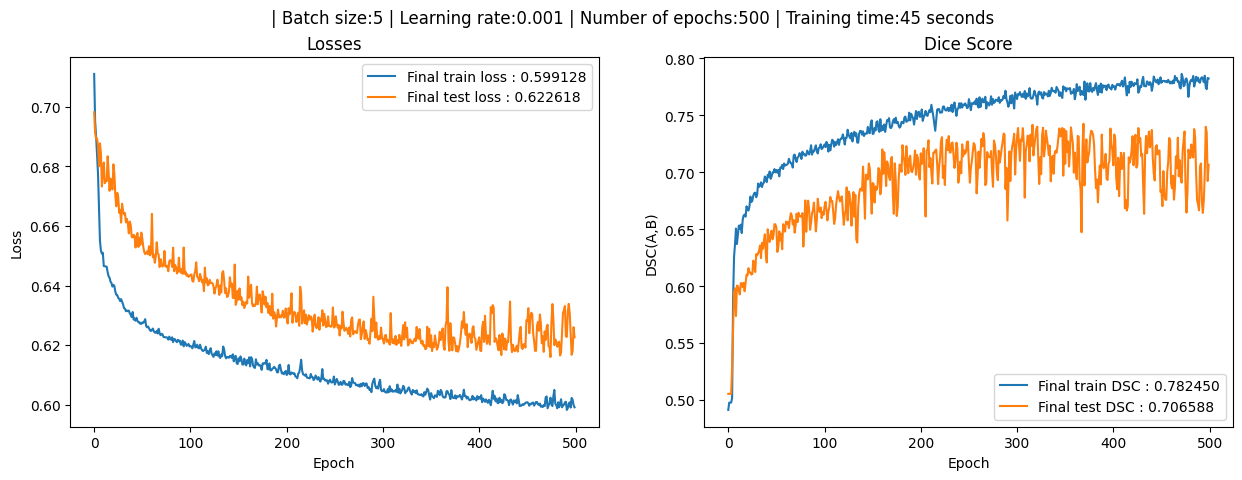

In [92]:
dropout_cnn = segment_learning(dropout_CNN_segment, 500, 0.001)

###L2 regularization

In [93]:
def regu_segment_learning(model_class, epochs, lr, weight_decay):
  model = model_class().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 10)

  train_loss, test_loss = [0]*epochs, [0]*epochs
  train_DSC, test_DSC = [0]*epochs, [0]*epochs

  start = time.time()
  for t in range(epochs):
      #print(f"Epoch {t+1}\n-------------------------------")
      train_loss[t], train_DSC[t] = segment_train(segment_trainloader, model, loss_segment, optimizer)
      test_loss[t], test_DSC[t] = segment_test(segment_testloader, model, loss_segment)
      #scheduler.step()

  end = time.time()
  train_time = end-start
  print("Done!")

  segment_plot_learning(train_loss, test_loss, train_DSC, test_DSC, lr, train_time, epochs)

  return model

Done!


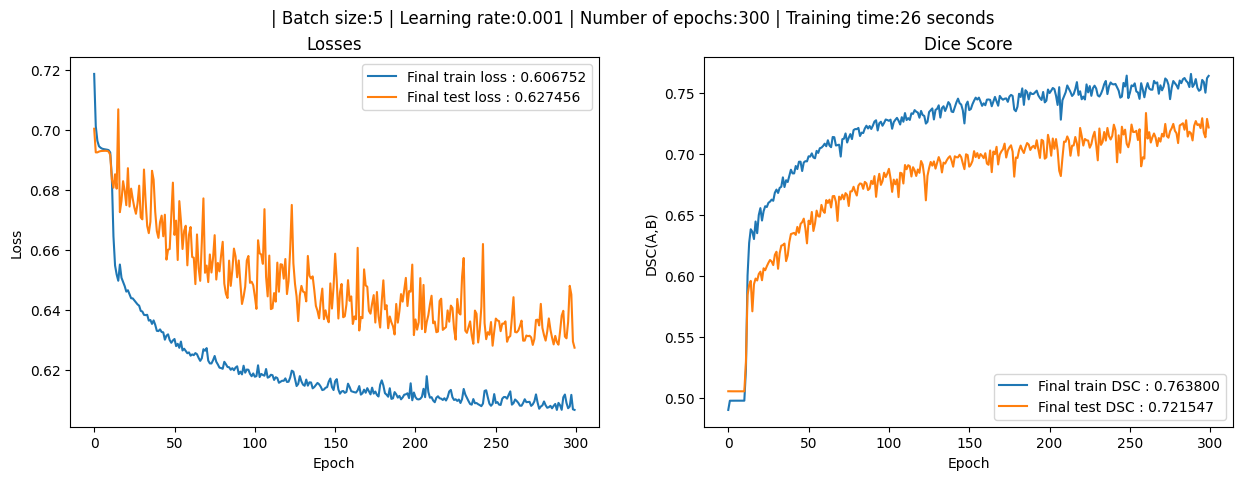

In [94]:
regu_segment_cnn = regu_segment_learning(shallower_CNN_segment, 300, 0.001, 0.00005)

# /!\ Work in progress /!\

## 2.3 Skip connections

In [ ]:
class skip_CNN_segment(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2,2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 64, 3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.tconv1 = nn.ConvTranspose2d(128, 32, 4, stride=2, padding=1)
        self.relu3 = nn.ReLU()
        self.tconv2 = nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x1 = self.conv1(x)
        x = self.pool1(x1)
        x = self.relu1(x)
        x2 = self.conv2(x)
        x = self.pool2(x2)

        x = self.tconv1(torch.cat((x2,x)))
        x = self.relu3(x)
        x = self.tconv2(torch.cat((x1,x)))
        x = self.sig(x)
        x = x.squeeze(dim=1) # Matching shape of the labels

        return x

In [ ]:
segment_learning(skip_CNN_segment, 300, 0.001)

##2.4 Residual connections

In [ ]:
class residual_CNN_segment(nn.Module):
    def __init__(self):
        super().__init__()
        self.conf0 = nn.Conv2d(3, 16, 3, stride=1, padding=1)

        self.conv1 = nn.Conv2d(16, 16, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 64, 3, stride=1, padding=1)

        self.pool1 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, stride=1, padding=1)

        self.pool2 = nn.MaxPool2d(2, 2)

        self.tconv1 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.tconv2 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)

        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x0 = self.conf0(x)

        x = self.ReLU()

        x1 = self.conv1(x)
        x1 = self.relu(x1)
        x1 = self.conv2(x1)

        x = self.relu(x1) + x0

        x = self.pool1(x)

        x2 = self.conv3(x)
        x2 = self.relu(x2)
        x2 = self.conv4(x2)

        x = self.relu(x2) + x

        x = self.pool2(x)

        x = self.tconv1(x)
        x = self.relu(x)
        x = self.tconv2(x)
        x = self.sig(x)
        x = x.squeeze(dim=1) # Matching shape of the labels

        return x

In [ ]:
segment_learning(residual_CNN_segment, 300, 0.001)